In [ ]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

# 1. Load and Preprocess Data
# ---------------------------
file_path = 'NEW_smilesforcompounds.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path, header=None)

# Convert the DataFrame column to a list of SMILES strings
smiles_list = data[0].tolist()

# 2. Generate Morgan Fingerprints
# -------------------------------
def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=2048):
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fingerprint = generator.GetFingerprint(mol)
            # Convert the fingerprint to a list
            fingerprints.append(list(fingerprint))
        else:
            fingerprints.append([None] * n_bits)
    return fingerprints

# Generate fingerprints with specified settings
radius = 2  # ECFP4 corresponds to a radius of 2
n_bits = 2048  # Size of the fingerprint
fingerprints = generate_morgan_fingerprints(smiles_list, radius=radius, n_bits=n_bits)

# Convert fingerprints to DataFrame
fingerprints_df = pd.DataFrame(fingerprints)

# 3. Label Data
# -------------
# Assuming binary labels for bioactivity (1 for active, 0 for inactive)
labels = [1 for i in range(112)] + [0 for i in range(112)]  # Adjust this according to your dataset
fingerprints_df['Bioactivity'] = labels

# 4. Train-Test Split
# -------------------
X = fingerprints_df.drop(columns=['Bioactivity'])  # Features
y = fingerprints_df['Bioactivity']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Hyperparameter Tuning with GridSearchCV
# ------------------------------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Retrieve the best model and hyperparameters
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# 6. Cross-Validation on the Best Model
# -------------------------------------
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 7. Evaluate the Best Model on the Test Set
# ------------------------------------------
y_pred = best_model.predict(X_test)

# Calculate performance metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")
print(f"Test Set AUC-ROC: {test_auc:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 8. Feature Importance
# ---------------------
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the top 10 feature rankings
print("\nTop 10 Feature Importances:")
for i in range(10):
    print(f"{i + 1}. Feature {indices[i]} ({importances[indices[i]]:.4f})")

# 9. Optionally Save Fingerprints and Labels to a CSV
# ---------------------------------------------------
fingerprints_df.to_csv("morgan_fingerprints_with_butt.csv", index=False)

In [26]:
import torch
import torch_geometric
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_smiles
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np

# 1. Load and Preprocess Data
# ---------------------------
file_path = 'NEW_smilesforcompounds.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path, header=None)

# Convert the DataFrame column to a list of SMILES strings
smiles_list = data[0].tolist()

# 2. Generate Conformers
# -----------------------
def generate_conformers(smiles, num_conformers=5):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens to the molecule
    AllChem.EmbedMultipleConfs(mol, numConfs=num_conformers, randomSeed=42)
    return mol

# 3. Convert Conformers to Graphs
# --------------------------------
def conformers_to_graphs(mol):
    graphs = []
    for conf in mol.GetConformers():
        mol.SetProp('_Name', str(conf.GetId()))  # Set the conformer ID as its name
        graph = from_smiles(Chem.MolToSmiles(mol))
        if graph is not None:
            graphs.append(graph)
    return graphs

# 4. Generate Data from SMILES with Conformers
# ---------------------------------------------
graph_data_list = []
labels = []

for i, smiles in enumerate(smiles_list):
    mol = generate_conformers(smiles)
    conformer_graphs = conformers_to_graphs(mol)
    label = 1 if i <= 112 else 0  # Adjust this according to your dataset


    for graph in conformer_graphs:
        graph.y = torch.tensor([label], dtype=torch.float)  # Ensure labels are of float type
        graph_data_list.append(graph)
        labels.append(label)

# 5. Train-Test Split
# -------------------
print(len(graph_data_list))
train_graphs, test_graphs = train_test_split(graph_data_list, test_size=0.2, random_state=42)
print(len(train_graphs)) 
print(len(test_graphs))


In [ ]:
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# 6. Define GNN Model
# -------------------
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=9, out_channels=64)  # Adjust `in_channels` based on your input node features
        self.conv2 = GCNConv(in_channels=64, out_channels=32)
        self.fc1 = torch.nn.Linear(32, 16)  # The input should match the `out_channels` of the last GCNConv layer
        self.fc2 = torch.nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index  # Ensure node features are of float type

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch_geometric.nn.global_mean_pool(x, data.batch)  # Global Pooling

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

# 7. Train the Model
# -------------------
def train(model, train_loader, optimizer):
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output.view(-1), data.y)
        loss.backward()
        optimizer.step()

# 8. Evaluate the Model
# ----------------------
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
            preds = (output.view(-1) > 0.5).float()
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

# 9. Main Training Loop
# ----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(model, train_loader, optimizer)

# Evaluate on the test set
y_true_test, y_pred_test = evaluate(model, test_loader)

# Calculate metrics
test_accuracy = accuracy_score(y_true_test, np.round(y_pred_test))
test_f1 = f1_score(y_true_test, np.round(y_pred_test))
test_auc = roc_auc_score(y_true_test, y_pred_test)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

# 10. Print Classification Report and Confusion Matrix
# ----------------------------------------------------
print("\nClassification Report:")
print(classification_report(y_true_test, np.round(y_pred_test)))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true_test, np.round(y_pred_test)))

In [ ]:
!pip install dgl xgboost lightgbm catboost keras


[LightGBM] [Info] Number of positive: 91, number of negative: 88
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 179, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508380 -> initscore=0.033523
[LightGBM] [Info] Start training from score 0.033523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/Users/shivanshbansal/miniconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/shivanshbansal/miniconda3/envs/myenv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.6953423023223877
Epoch 2, Loss: 0.6920979420344034
Epoch 3, Loss: 0.6856721838315328
Epoch 4, Loss: 0.6828478078047434
Epoch 5, Loss: 0.6594392160574595
Epoch 6, Loss: 0.6286941270033518
Epoch 7, Loss: 0.6432088911533356
Epoch 8, Loss: 0.5911450982093811
Epoch 9, Loss: 0.5587692459424337
Epoch 10, Loss: 0.5214469482501348
Epoch 11, Loss: 0.524669736623764
Epoch 12, Loss: 0.5016248573859533
Epoch 13, Loss: 0.4636682868003845
Epoch 14, Loss: 0.4563075552384059
Epoch 15, Loss: 0.4809613873561223
Epoch 16, Loss: 0.4416976869106293
Epoch 17, Loss: 0.41723179320494336
Epoch 18, Loss: 0.4237655798594157
Epoch 19, Loss: 0.4565829237302144
Epoch 20, Loss: 0.4056927412748337


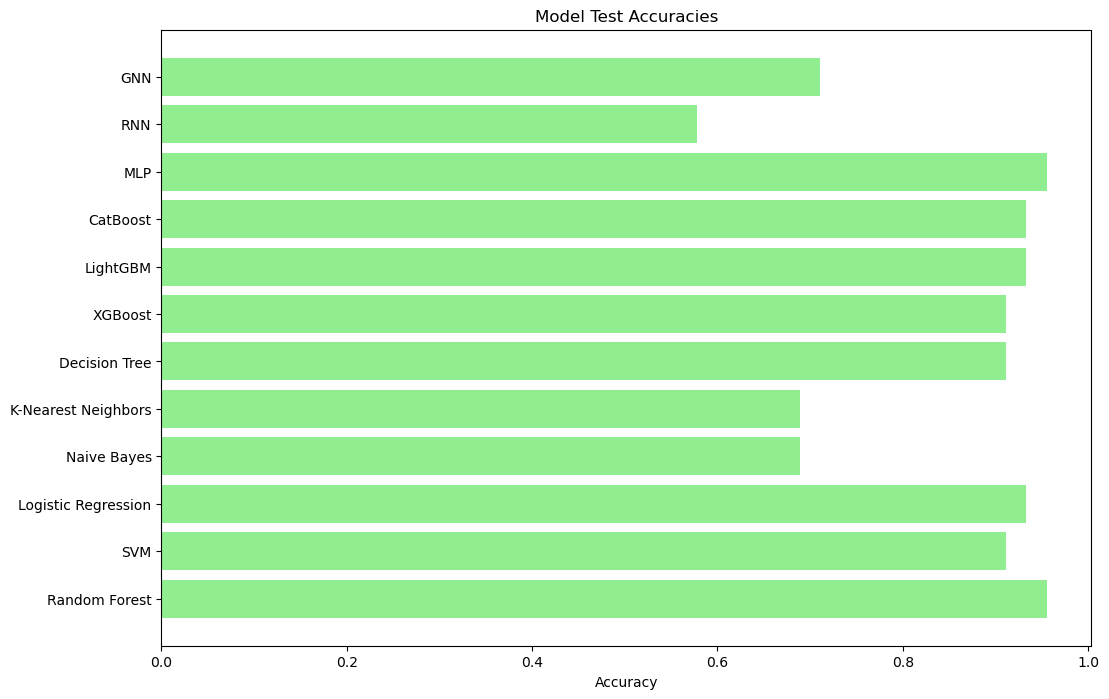

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_smiles
from tensorflow.keras import layers, models  # Keras models for MLP and RNN

# 1. Load and Preprocess Data
file_path = 'NEW_smilesforcompounds.csv'
data = pd.read_csv(file_path, header=None)
smiles_list = data[0].tolist()
labels = [1] * 112 + [0] * 112  # Update according to your dataset

# 2. Generate MACCS Fingerprints
def generate_maccs_fingerprints(smiles_list):
    fingerprints = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        fp = MACCSkeys.GenMACCSKeys(mol)
        fingerprints.append(np.array(fp))
    return pd.DataFrame(fingerprints)

fingerprints_df = generate_maccs_fingerprints(smiles_list)
fingerprints_df['Bioactivity'] = labels

# Save fingerprints to a CSV file
fingerprints_df.to_csv('maccs_fingerprints.csv', index=False)

X = fingerprints_df.drop(columns=['Bioactivity'])
y = fingerprints_df['Bioactivity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define and Train Traditional ML Models
ml_models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
}

train_accuracies = {}
test_accuracies = {}

for name, model in ml_models.items():
    model.fit(X_train, y_train)
    train_accuracies[name] = model.score(X_train, y_train)
    test_accuracies[name] = model.score(X_test, y_test)

# 4. Define and Train Neural Network Models
# MLP Model
def create_mlp(input_shape):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

mlp_model = create_mlp(X_train.shape[1])
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
train_accuracies["MLP"] = mlp_model.evaluate(X_train, y_train, verbose=0)[1]
test_accuracies["MLP"] = mlp_model.evaluate(X_test, y_test, verbose=0)[1]

# RNN Model (using LSTM)
def create_rnn(input_shape):
    model = models.Sequential([
        layers.Embedding(input_dim=input_shape, output_dim=128),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = create_rnn(X_train.shape[1])
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
train_accuracies["RNN"] = rnn_model.evaluate(X_train, y_train, verbose=0)[1]
test_accuracies["RNN"] = rnn_model.evaluate(X_test, y_test, verbose=0)[1]

# 5. Define the GNN Model using PyTorch Geometric
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=9, out_channels=64)
        self.conv2 = GCNConv(in_channels=64, out_channels=32)
        self.fc1 = torch.nn.Linear(32, 16)
        self.fc2 = torch.nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index  # Ensure x is Float
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch_geometric.nn.global_mean_pool(x, data.batch)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

# 6. Train and Evaluate the GNN Model
def smiles_to_graph(smiles_list):
    graphs = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        graph = from_smiles(smiles)
        if graph:
            graphs.append(graph)
    return graphs

graphs = smiles_to_graph(smiles_list)
for i, graph in enumerate(graphs):
    graph.y = torch.tensor([labels[i]], dtype=torch.float)

train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

def train_model(model, loader, optimizer, loss_fn):
    model.train()
    for epoch in range(20):
        total_loss = 0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = loss_fn(output.view(-1), batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(loader)}')

train_model(model, train_loader, optimizer, loss_fn)

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch)
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(output.view(-1).cpu().numpy())
    return y_true, y_pred

y_true_train, y_pred_train = evaluate_model(model, train_loader)
y_true_test, y_pred_test = evaluate_model(model, test_loader)

train_accuracy = accuracy_score(y_true_train, np.round(y_pred_train))
test_accuracy = accuracy_score(y_true_test, np.round(y_pred_test))
train_accuracies["GNN"] = train_accuracy
test_accuracies["GNN"] = test_accuracy

# 7. Plot Accuracies
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(list(test_accuracies.keys()), list(test_accuracies.values()), color='lightgreen')
ax.set_xlabel('Accuracy')
ax.set_title('Model Test Accuracies')
plt.show()
